In [32]:
import torch
import pandas
import json
import sys
import os
sys.path.insert(0, os.path.join(".."))
from models.LSenTiMent import LSenTiMent
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Computer Modern Roman']

In [33]:
def get_model(name):
    with open(os.path.join("../models/final", f"{name}_params.json"), "r") as f:
        params = json.load(f)

    model = LSenTiMent(
        input_size=1,
        hidden_size1=params["lstm1_hidden_size"],
        num_layers1=params["lstm1_num_layers"],
        hidden_size2=params["lstm2_hidden_size"],
        num_layers2=params["lstm2_num_layers"],
        window_size=10,
        mlp_layers=params["mlp_layers"],
        mlp_hidden_size=params["mlp_hidden_size"],
        dropout_rate=params["dropout_rate"],
        sentiment=params["use_sentiment"],
        double=params["double"]
    )

    model.load_state_dict(torch.load(os.path.join("../models/final", f"{name}.pt")))

    return model

In [34]:
model_no_sentiment = get_model("model_no_sentiment")
model_sentiment_single = get_model("model_sentiment_single")
model_sentiment_double = get_model("model_sentiment_double")

In [35]:
with open("../data/split/Xy_test.pkl", "rb") as f:
    Xy_test = pickle.load(f)

test_names = ["amazon", "apple", "google", "meta", "netflix"]

Amazon
No sentiment loss: 0.0009887060150504112
Sentiment single loss: 0.0017344020307064056
Sentiment double loss: 0.0026770257391035557

Apple
No sentiment loss: 0.0012858783593401313
Sentiment single loss: 0.002263421891257167
Sentiment double loss: 0.003745057387277484

Google
No sentiment loss: 0.00121504592243582
Sentiment single loss: 0.0015555944992229342
Sentiment double loss: 0.008728278800845146

Meta
No sentiment loss: 0.039174169301986694
Sentiment single loss: 0.06822118163108826
Sentiment double loss: 0.10135246813297272

Netflix
No sentiment loss: 0.02892322465777397
Sentiment single loss: 0.033223237842321396
Sentiment double loss: 0.08439161628484726



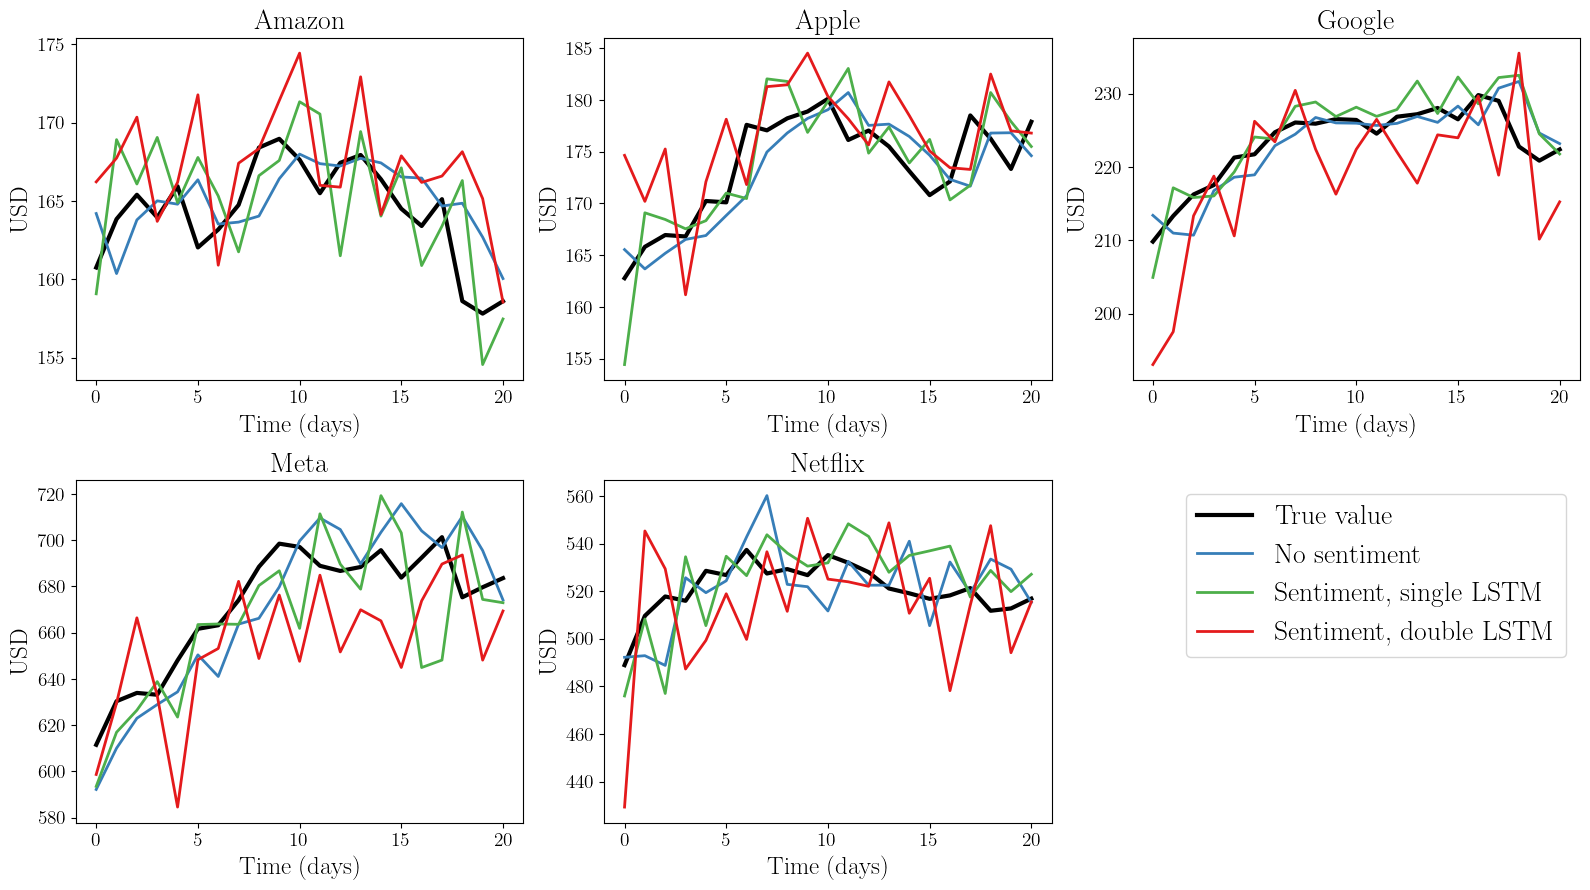

In [38]:
with open("../data/split/norms.json") as f:
    norms = json.load(f)

def usd(x):
    return x * norms["price_std"] + norms["price_mean"]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 9))
ax = ax.ravel()

for i in range(len(Xy_test)):
    y = Xy_test[i][1].detach().numpy()
    y_no_sentiment = model_no_sentiment(Xy_test[i][0][:, :, 0:1]).detach().numpy()
    y_sentiment_single = model_sentiment_single(Xy_test[i][0]).detach().numpy()
    y_sentiment_double = model_sentiment_double(Xy_test[i][0]).detach().numpy()

    name = test_names[i]
    name = name[0].upper() + name[1:]

    print(name)
    print(f"No sentiment loss: {np.mean((y - y_no_sentiment) ** 2)}")
    print(f"Sentiment single loss: {np.mean((y - y_sentiment_single) ** 2)}")
    print(f"Sentiment double loss: {np.mean((y - y_sentiment_double) ** 2)}")
    print()

    y = usd(y)
    y_no_sentiment = usd(y_no_sentiment)
    y_sentiment_single = usd(y_sentiment_single)
    y_sentiment_double = usd(y_sentiment_double)

    ax[i].set_title(name, fontsize=20)

    ax[i].plot(y, color="black", linewidth=3)
    ax[i].plot(y_no_sentiment, linewidth=2, color="#377eb8")
    ax[i].plot(y_sentiment_single, linewidth=2, color="#4daf4a")
    ax[i].plot(y_sentiment_double, linewidth=2, color="#e41a1c")

    ax[i].tick_params(axis='both', labelsize=14)
    ax[i].set_xlabel("Time (days)", fontsize=18)
    ax[i].set_ylabel("USD", fontsize=18)

    # print(f"{test_names[i]}: true = {Xy_test[i][1].item()}, no_sentiment = {y_no_sentiment}, sentiment_double = {y_sentiment_double}")
    # print(f"\t \t true = {usd(Xy_test[i][1].item())} USD, no_sentiment = {usd(y_no_sentiment)} USD, sentiment_double = {usd(y_sentiment_double)} USD")

ax[-1].axis("off")
ax[-1].plot([], color="black", linewidth=3, label="True value")
ax[-1].plot([], color="#377eb8", linewidth=2, label="No sentiment")
ax[-1].plot([], color="#4daf4a", linewidth=2, label="Sentiment, single LSTM")
ax[-1].plot([], color="#e41a1c", linewidth=2, label="Sentiment, double LSTM")
ax[-1].legend(fontsize=20)

plt.tight_layout()
plt.savefig("test.pdf")
plt.show()